In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy import arange, array, exp
from tqdm import tqdm

In [4]:
# Define constants. all units in SI
q = 1 #emission rate, kg/s
u = 7 #wind speed, m/s
h0 = 20 #stack height, m
z0 = 2e-4 #aerodynamic roughness, m
srho = 125 # particle material density, kg/m3
smass = 0.3e9 #total mass of particles released, kg

#turbulent wind speed fluctuations
iy = 0.88/(np.log(h0/z0)-1)
print(iy)
iz = 0.5/(np.log(h0/z0)-1)
print(iz)

0.08370648141016684
0.047560500801231156


### Set up utility functions to calculate particle concentrations

In [100]:
stokev(32.5e-6)

0.016515807538530984

In [5]:
def stokev(r):
    #returns stoke velocity for glass spheres of radius r
    return 2/9*(125-1.29)/1.723e-5*9.8*r**2

def delx(x,r):
    #returns the deviation of the centerline as a function of position x and size r
    return x/u*stokev(r)

def xedge(r):
    #returns the lower edge at dsigma and the center line position of the plume on the ground and 
    angle3 = np.arctan(u/stokev(r))
    angle1 = np.arctan(dsigma*iz)
    xl = h0*np.tan(angle3-angle1)
    xm = h0*np.tan(angle3)#+angle1)
    return [xl, xm]


# standard deviation of the plume conc. along y
def sigmay_val(x): return iy*x
# standard deviation of the plume conc. along x
def sigmaz_val(x): return iz*x

def xrel_calc(x,r):
    #project the plume coordinate to absolute. xrel is x position along plume center
    angle3 = np.arctan(u/stokev(r))
    anglex = np.arctan(x/h0)
    angle1 = angle3-anglex
    xrel = x*np.cos(angle1)/np.sin(anglex) 
    return xrel

def conc_g(x, y, r, z=0):
    #returns concentration (kg/m3) at the ground level at position x, y, z for particles with size r
    #[xl,xm] = xedge(r)
#    if x>xm: 
#        x = xm-(x-xm)
    xrel = xrel_calc(x,r)
    sigmay = sigmay_val(xrel)
    sigmaz = sigmaz_val(xrel)
    c = q/u/np.pi/sigmay/sigmaz*np.exp(-y**2/2/sigmay**2)*np.exp(-(z-(h0-delx(x,r)))**2/2/sigmaz**2)
    return c


### Extrapolate albedo as a function of particle layer thickness. 
- Showing linear extrapolation and Logistic function fitting
- Currently using the logistic function fit

C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp
C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead


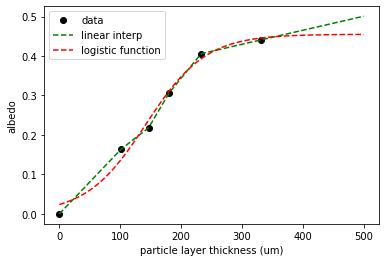

In [6]:
thk = [0.1,101.55,146.7,180.7,233,331]
albedo = [0, 0.163870968,0.218064516,0.307096774,0.405806452,0.440645161]

def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return array(list(map(pointwise, array(xs))))

    return ufunclike

def func(x, a, b, k): # the logistic function form
    return a/(1+b*np.exp(-k*x))
popt, pcov = curve_fit(func, thk, albedo)#, bounds=(0, [0.2, 0.2]))


f = interp1d(thk, albedo, kind='slinear')
f_x = extrap1d(f)
xnew = np.linspace(0, 500, 100)
plt.figure()
plt.plot(thk,albedo,'ko')
plt.plot(xnew, f_x(xnew), 'g--')
plt.plot(xnew, func(xnew, *popt), 'r--')
plt.xlabel('particle layer thickness (um)')
plt.ylabel('albedo')
plt.legend(['data','linear interp', 'logistic function'])

### Calculate distribution of spheres on a grid
- The grid range is defined by assuming that any grid with an average particle thickness of <0.1 nm is empty
- The grid resolution was tested so that changing the the resolution does not change the resulting plume shape estimate

- for these plots, assume a particle size of 1000 um

In [94]:
#helper functions to calculate particle distribution on a grid
def conc2thk(r, conc):
    #return a layer thickness according to the conctration of particles here
    #conc in kg/m2
    pdensity = np.sqrt(2)/6*np.pi #spatial density assuming closest packing
    thk = conc/srho/pdensity
    return thk

def dens_calc(xcoord, ycoord, r):
    #return a particle density matrix (arbitratry units)
    xgrid = len(xcoord); ygrid = len(ycoord)
    dens = np.zeros([xgrid,ygrid])
    for i in range(xgrid):
        for j in range(ygrid):
            dens[i,j] = conc_g(xcoord[i],ycoord[j],r)
    dens[np.isnan(dens)] = 0
    return dens


def dens2conc(dens,xcoord,ycoord):
    # convert a unitless density matrix to a particle density matrix in kg/m2
    garea = (xcoord[1]-xcoord[0])*(ycoord[1]-ycoord[0]) #grid area in m2
    dens_mass = garea*np.nansum(dens)
    dens = dens*(smass/dens_mass) # normalize particle mass so it sums to the total mass distributed
    return dens

def gridrange(ctthk = 1e-6):
    #return range of grid with a thk cutoff of ctthk (m) by a coarse grid search
    # search a large area with a coarse grid
    n = 201
    xrng = np.array([0,1000]); yrng = np.array([-50,50])
    xgrid = n; ygrid = n
    
    xcoord = np.linspace(xrng[0],xrng[1],xgrid)
    ycoord = np.linspace(yrng[0],yrng[1],ygrid)
    
    dens = dens_calc(xcoord, ycoord)
    dens = dens2conc(dens,xcoord,ycoord)
    dens = conc2thk(r,dens)
    dens[dens<ctthk] = 0; 
    border_idx = np.nonzero(dens)
    xmax = xcoord[max(border_idx[0])]
    ymin = ycoord[min(border_idx[1])]; ymax = ycoord[max(border_idx[1])]
    return xmax+np.ptp(xcoord)/xgrid/2, ymin-np.ptp(ycoord)/ygrid/2, ymax+np.ptp(ycoord)/ygrid/2



In [95]:
[xmax, ymin, ymax] = gridrange()

C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


In [96]:
print(xmax)
print((ymin,ymax))

212.48756218905473
(-46.24875621890547, 46.24875621890547)


In [124]:
#calculate plume distribution
# define particle size and the grid
r = 32.5e-6 # particle radius, m
xmax = 480000
ymin = -35000
ymax = 35000
n = 5001 #grid resolution
ctthk = 1e-5

xgrid = n; ygrid = n
xrng = np.array([0,xmax]); yrng = np.array([ymin,ymax])

xcoord = np.linspace(xrng[0],xrng[1],xgrid)#+xmax/xgrid/2
ycoord = np.linspace(yrng[0],yrng[1],ygrid)#+(ymax-ymin)/ygrid/2

dens = dens_calc(xcoord, ycoord, r)
dens = dens2conc(dens,xcoord,ycoord)
dens = conc2thk(r, dens)




C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


C:\Users\dzsaf\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


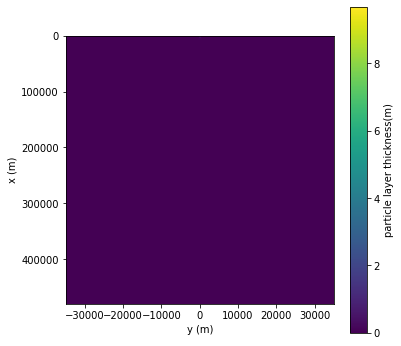

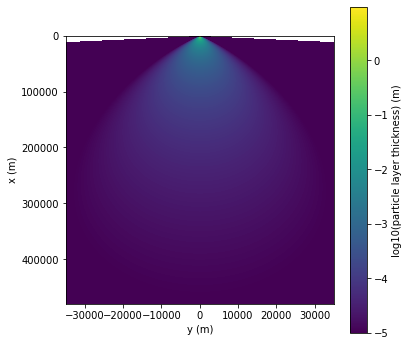

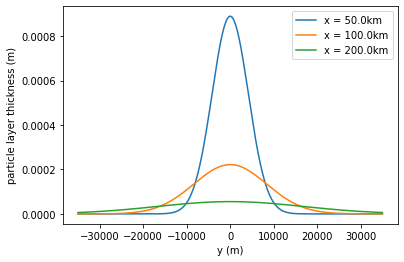

In [131]:
#plot plume distribution

#dens[dens<ctthk] = 0
#linear scale
fig, ax = plt.subplots(figsize=(6,6))
pos = ax.imshow(dens, extent=[yrng[0],yrng[1],xrng[1],xrng[0]])#, vmax = 5e-24)
ax.set_aspect((ymax-ymin)/xmax)
cbar = fig.colorbar(pos)
cbar.set_label('particle layer thickness(m)')
plt.xlabel('y (m)')
plt.ylabel('x (m)')

#log scale
fig, ax = plt.subplots(figsize=(6,6))
pos = ax.imshow(np.log10(dens), extent=[yrng[0],yrng[1],xrng[1],xrng[0]], vmin = -5)
ax.set_aspect((ymax-ymin)/xmax)
cbar = fig.colorbar(pos)
cbar.set_label('log10(particle layer thickness) (m)')
plt.xlabel('y (m)')
plt.ylabel('x (m)')


#plot plume profile at various distances
prof_dist = [50000,100000,200000]
plt.figure()
for d in prof_dist:
    plt.plot(ycoord, dens[int(d/xmax*n),:])
plt.xlabel('y (m)')
plt.ylabel('particle layer thickness (m)')
plt.legend(['x = '+str(d/1000)+'km' for d in prof_dist])

### calculate plume radiative efficiency
- Define the radiative efficiency as:
    - actual average albedo change based on the plume distribution/ average albedo change assuming a monolayer of particles

In [65]:
iarea = smass/srho/(4/3*np.pi*r**3)*r**2*4 #area the particles would cover under an ideal monolayer distribution
ialbedo = func(r*2*1e6, *popt)

In [134]:
garea = (xcoord[1]-xcoord[0])*(ycoord[1]-ycoord[0])
plume_alpha = 0
for i in tqdm(range(dens.shape[0])):
    for j in range(dens.shape[1]):
        plume_alpha+= func(dens[i,j], *popt)
        

In [138]:
rad_eff = plume_alpha*garea/(ialbedo*iarea)
print('the radiative efficiency of the plume is {}'.format(rad_eff))

the radiative efficiency of the plume is 0.14482596013829147
